##  To develop a customer segmentation to define marketing strategy for credit card holders

In [1]:
# Importing the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as stats
import pandas_profiling   

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cluster import KMeans

# center and scale the data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn.metrics as metrics

In [2]:
# Importing data
ccms= pd.read_csv("CC_GENERAL.csv")

In [3]:
ccms.head(2)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.4,0.0,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.0,0.0,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12


In [4]:
ccms.shape

(8950, 18)

In [5]:
# Adding new KPI as per data dictionary
ccms['MONTHLY_AVERAGE_PURCHASE']=ccms.PURCHASES/ccms.TENURE
ccms['MONTHLY_CASH_ADVANCE']=ccms.CASH_ADVANCE/ccms.TENURE
ccms['LIMIT_USAGE']=ccms.BALANCE/ccms.CREDIT_LIMIT
ccms['PTMR']=ccms.PAYMENTS/ccms.MINIMUM_PAYMENTS
ccms['AVERAGE_PURCHASE_TRX']=ccms.PURCHASES/ccms.PURCHASES_TRX

In [6]:
from numpy import where as IF

In [7]:
ccms['PURCHASE_TYPES']=IF((ccms.ONEOFF_PURCHASES==0) & (ccms.INSTALLMENTS_PURCHASES==0), 'NONE',
   IF((ccms.ONEOFF_PURCHASES>0) & (ccms.INSTALLMENTS_PURCHASES==0), 'ONE-OFF',
      IF((ccms.ONEOFF_PURCHASES==0) & (ccms.INSTALLMENTS_PURCHASES>0),'Installment Purchases',
         IF((ccms.ONEOFF_PURCHASES>0) & (ccms.INSTALLMENTS_PURCHASES>0),'Both','Invalid'))))

In [8]:
ccms.shape

(8950, 24)

In [9]:
ccms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 24 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8949 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS            

In [10]:
#Profile Report using pandas profiling 
#profile_report = pandas_profiling.ProfileReport(ccms)
#profile_report.to_file('profile_report.html')

In [11]:
# Dropping column due to high cardinality
ccms=ccms.drop(columns=['CUST_ID'])

In [12]:
numeric_var_names=[key for key in dict(ccms.dtypes) if dict(ccms.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(ccms.dtypes) if dict(ccms.dtypes)[key] in ['object']]
print(numeric_var_names)
print(cat_var_names)

['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE', 'MONTHLY_AVERAGE_PURCHASE', 'MONTHLY_CASH_ADVANCE', 'LIMIT_USAGE', 'PTMR', 'AVERAGE_PURCHASE_TRX']
['PURCHASE_TYPES']


In [13]:
ccms_num=ccms[numeric_var_names]
ccms_num.head(5)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,MONTHLY_AVERAGE_PURCHASE,MONTHLY_CASH_ADVANCE,LIMIT_USAGE,PTMR,AVERAGE_PURCHASE_TRX
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,1000.0,201.802084,139.509787,0.000000,12,7.950000,0.000000,0.040901,1.446508,47.700000
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,7000.0,4103.032597,1072.340217,0.222222,12,0.000000,536.912124,0.457495,3.826241,NaN
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,7500.0,622.066742,627.284787,0.000000,12,64.430833,0.000000,0.332687,0.991682,64.430833
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,7500.0,0.000000,NaN,0.000000,12,124.916667,17.149001,0.222223,NaN,1499.000000
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,1200.0,678.334763,244.791237,0.000000,12,1.333333,0.000000,0.681429,2.771075,16.000000


In [14]:
ccms_cat = ccms[cat_var_names]
ccms_cat.head(5)

,PURCHASE_TYPES
0,Installment Purchases
1,NONE
2,ONE-OFF
3,ONE-OFF
4,ONE-OFF


In [15]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=ccms_num.apply(lambda x: var_summary(x)).T

In [16]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
BALANCE,8950.0,0.0,1.400205e+07,1564.474828,873.385231,2081.531879,4.332775e+06,0.000000,0.065101,8.814518,23.575529,128.281915,873.385231,2054.140036,4338.563657,5909.111808,9338.804814,1.904314e+04
BALANCE_FREQUENCY,8950.0,0.0,7.851573e+03,0.877271,1.000000,0.236904,5.612351e-02,0.000000,0.090909,0.272727,0.454545,0.888889,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00
PURCHASES,8950.0,0.0,8.978683e+06,1003.204834,361.280000,2136.634782,4.565208e+06,0.000000,0.000000,0.000000,0.000000,39.635000,361.280000,1110.130000,2542.624000,3998.619500,8977.290000,4.903957e+04
ONEOFF_PURCHASES,8950.0,0.0,5.302314e+06,592.437371,38.000000,1659.887917,2.755228e+06,0.000000,0.000000,0.000000,0.000000,0.000000,38.000000,577.405000,1600.099000,2671.094000,6689.898200,4.076125e+04
INSTALLMENTS_PURCHASES,8950.0,0.0,3.679055e+06,411.067645,89.000000,904.338115,8.178274e+05,0.000000,0.000000,0.000000,0.000000,0.000000,89.000000,468.637500,1140.070000,1750.087500,3886.240500,2.250000e+04
CASH_ADVANCE,8950.0,0.0,8.760896e+06,978.871112,0.000000,2097.163877,4.398096e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1113.821139,3065.534560,4647.169122,9588.163357,4.713721e+04
PURCHASES_FREQUENCY,8950.0,0.0,4.388637e+03,0.490351,0.500000,0.401371,1.610985e-01,0.000000,0.000000,0.000000,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000,1.000000,1.000000e+00
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.0,1.811996e+03,0.202458,0.083333,0.298336,8.900441e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.300000,0.750000,1.000000,1.000000,1.000000e+00
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.0,3.261714e+03,0.364437,0.166667,0.397448,1.579647e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000,1.000000,1.000000e+00
CASH_ADVANCE_FREQUENCY,8950.0,0.0,1.209541e+03,0.135144,0.000000,0.200121,4.004857e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.416667,0.583333,0.833333,1.500000e+00


In [17]:
#Handling Outliers - Capping @ 95th & 5th percentile
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.95))
    x = x.clip_lower(x.quantile(0.05))
    return x

ccms_num=ccms_num.apply(lambda x: outlier_capping(x))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  after removing the cwd from sys.path.


In [18]:
#Handling missings
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

ccms_num=ccms_num.apply(lambda x: Missing_imputation(x))

In [19]:
ccms_num.corr()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,MONTHLY_AVERAGE_PURCHASE,MONTHLY_CASH_ADVANCE,LIMIT_USAGE,PTMR,AVERAGE_PURCHASE_TRX
BALANCE,1.000000,0.370254,0.124336,0.138493,0.040367,0.565401,-0.102891,0.070789,-0.089514,0.489843,...,0.510543,0.347819,0.774570,-0.359881,0.075801,0.118802,0.543382,0.619571,-0.291104,0.044369
BALANCE_FREQUENCY,0.370254,1.000000,0.192937,0.153188,0.170524,0.116485,0.237081,0.204411,0.184918,0.200011,...,0.105576,0.124358,0.291212,-0.111917,0.133089,0.187511,0.103147,0.456831,-0.222249,-0.072572
PURCHASES,0.124336,0.192937,1.000000,0.865282,0.710001,-0.137265,0.589131,0.658719,0.461632,-0.187429,...,0.348476,0.515077,0.110925,0.215231,0.121018,0.994094,-0.143318,-0.113876,0.401123,0.356612
ONEOFF_PURCHASES,0.138493,0.153188,0.865282,1.000000,0.319737,-0.092469,0.394927,0.764991,0.168362,-0.121483,...,0.336708,0.456999,0.064326,0.127898,0.087760,0.863161,-0.097293,-0.078613,0.354370,0.397624
INSTALLMENTS_PURCHASES,0.040367,0.170524,0.710001,0.319737,1.000000,-0.147078,0.639240,0.251237,0.729578,-0.200741,...,0.210151,0.338280,0.107588,0.238894,0.116144,0.702986,-0.152415,-0.122431,0.278015,0.086146
CASH_ADVANCE,0.565401,0.116485,-0.137265,-0.092469,-0.147078,1.000000,-0.286882,-0.122090,-0.238361,0.739399,...,0.307893,0.375003,0.398422,-0.211834,-0.097117,-0.134462,0.989460,0.303500,-0.043786,-0.014646
PURCHASES_FREQUENCY,-0.102891,0.237081,0.589131,0.394927,0.639240,-0.286882,1.000000,0.501343,0.862934,-0.333006,...,0.115903,0.146167,-0.022452,0.305802,0.069300,0.589490,-0.288386,-0.227169,0.173213,-0.120429
ONEOFF_PURCHASES_FREQUENCY,0.070789,0.204411,0.658719,0.764991,0.251237,-0.122090,0.501343,1.000000,0.142329,-0.125492,...,0.298759,0.316838,0.003956,0.157531,0.087045,0.656923,-0.124294,-0.096461,0.276387,0.106908
PURCHASES_INSTALLMENTS_FREQUENCY,-0.089514,0.184918,0.461632,0.168362,0.729578,-0.238361,0.862934,0.142329,1.000000,-0.282139,...,0.054047,0.110787,0.007014,0.250087,0.079282,0.457713,-0.240906,-0.185014,0.119955,-0.207508
CASH_ADVANCE_FREQUENCY,0.489843,0.200011,-0.187429,-0.121483,-0.200741,0.739399,-0.333006,-0.125492,-0.282139,1.000000,...,0.134653,0.214712,0.331363,-0.267346,-0.127201,-0.182080,0.740138,0.422815,-0.126277,-0.056532


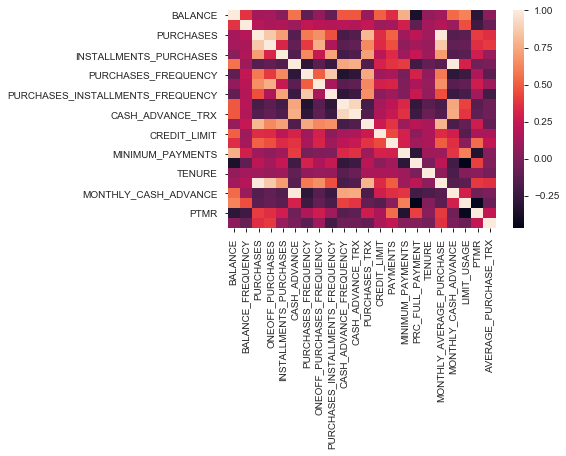

In [20]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(ccms_num.corr())

### Standardrizing data 
- To put data on the same scale 

In [21]:
ccms_num.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'MONTHLY_AVERAGE_PURCHASE', 'MONTHLY_CASH_ADVANCE',
       'LIMIT_USAGE', 'PTMR', 'AVERAGE_PURCHASE_TRX'],
      dtype='object')

In [22]:
sc=StandardScaler()
#sc.fit()
#sc.transform()

In [23]:
ccms_scaled=sc.fit_transform(ccms_num)

In [24]:
pd.DataFrame(ccms_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.835783,-0.297904,-0.662389,-0.600394,-0.483999,-0.605707,-0.806490,-0.678661,-0.707313,-0.722502,...,-1.049768,-0.800356,-0.686097,-0.525551,0.378995,-0.672440,-0.600126,-0.990006,-0.575627,-0.419986
1,1.036257,0.118296,-0.749136,-0.600394,-0.675642,2.838929,-1.221758,-0.678661,-0.916995,0.692644,...,0.821198,1.643245,0.613947,0.234227,0.378995,-0.757187,2.868023,0.212144,-0.149929,-0.289864
2,0.617437,0.534496,-0.046095,0.435900,-0.675642,-0.605707,1.269843,2.673451,-0.916995,-0.722502,...,0.977112,-0.537116,-0.006307,-0.525551,0.378995,-0.070357,-0.600126,-0.148012,-0.656989,-0.139378
3,0.126875,-1.130304,0.613899,1.408742,-0.675642,-0.453170,-1.014125,-0.399319,-0.916995,-0.250789,...,0.977112,-0.870392,-0.445226,-0.525551,0.378995,0.574420,-0.460364,-0.466773,-0.446117,3.451870
4,-0.375812,0.534496,-0.734587,-0.578948,-0.675642,-0.605707,-1.014125,-0.399319,-0.916995,-0.722502,...,-0.987403,-0.501872,-0.539371,-0.525551,0.378995,-0.742974,-0.600126,0.858340,-0.338682,-0.951655


### Applying PCA

In [25]:
pc = PCA(n_components=22)

In [26]:
pc.fit(ccms_scaled)

PCA(copy=True, iterated_power='auto', n_components=22, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [27]:
pc.explained_variance_

array([6.46152029e+00, 4.93623033e+00, 2.30107611e+00, 1.69629666e+00,
       1.15332962e+00, 9.97319153e-01, 8.90988442e-01, 7.11642964e-01,
       6.27015188e-01, 5.22866534e-01, 3.91810082e-01, 3.27555013e-01,
       2.29078170e-01, 2.15755721e-01, 1.65553394e-01, 1.08174506e-01,
       1.05734946e-01, 7.67846447e-02, 4.67974029e-02, 2.64682834e-02,
       7.03433361e-03, 3.42658821e-03])

In [28]:
#Eigen values
sum(pc.explained_variance_)

22.00245837523745

In [29]:
#The amount of variance that each PC explains
var= pc.explained_variance_ratio_

In [30]:
var

array([2.93672651e-01, 2.24349036e-01, 1.04582682e-01, 7.70957787e-02,
       5.24182161e-02, 4.53276237e-02, 4.04949496e-02, 3.23437932e-02,
       2.84975059e-02, 2.37640052e-02, 1.78075593e-02, 1.48872006e-02,
       1.04114807e-02, 9.80598248e-03, 7.52431348e-03, 4.91647360e-03,
       4.80559693e-03, 3.48982116e-03, 2.12691701e-03, 1.20296937e-03,
       3.19706711e-04, 1.55736607e-04])

In [31]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pc.explained_variance_ratio_, decimals=4)*100)

In [32]:
var1

array([29.37, 51.8 , 62.26, 69.97, 75.21, 79.74, 83.79, 87.02, 89.87,
       92.25, 94.03, 95.52, 96.56, 97.54, 98.29, 98.78, 99.26, 99.61,
       99.82, 99.94, 99.97, 99.99])

Number of components based on cumulative variance explaining >79 % and individual component explaining >0.8 variance is 6


In [33]:
pc_final=PCA(n_components=6).fit(ccms_scaled)

In [34]:
pc_final.explained_variance_

array([6.46152029, 4.93623033, 2.30107611, 1.69629666, 1.15332962,
       0.99731915])

In [35]:
reduced_cr=pc_final.transform(ccms_scaled)  # the out put is Factors (F1, F2, ...F6)

In [36]:
dimensions = pd.DataFrame(reduced_cr)

In [37]:
dimensions.head()

,0,1,2,3,4,5
0,-1.406201,-2.519853,-0.110912,0.452369,-0.250805,-0.249148
1,-2.818479,2.972298,1.607845,-1.028851,-1.322599,-0.137448
2,1.000822,-0.084049,-0.764866,1.714233,0.097817,-1.949330
3,0.113002,-0.433702,1.953994,3.246067,-0.267137,1.462193
4,-1.769001,-1.650365,-0.920077,0.940278,-0.059890,-0.799368


In [38]:
dimensions.columns = ["C1", "C2", "C3", "C4", "C5", "C6"]

In [39]:
dimensions.head()

,C1,C2,C3,C4,C5,C6
0,-1.406201,-2.519853,-0.110912,0.452369,-0.250805,-0.249148
1,-2.818479,2.972298,1.607845,-1.028851,-1.322599,-0.137448
2,1.000822,-0.084049,-0.764866,1.714233,0.097817,-1.949330
3,0.113002,-0.433702,1.953994,3.246067,-0.267137,1.462193
4,-1.769001,-1.650365,-0.920077,0.940278,-0.059890,-0.799368


#### Factor Loading Matrix

Loadings=Eigenvectors * sqrt(Eigenvalues)

loadings are the covariances/correlations between the original variables and the unit-scaled components.

In [40]:
#pc_final.components_

#print pd.DataFrame(pc_final.components_,columns=telco_num.columns).T

# Loadings =  pd.DataFrame((pc_final.components_.T * np.sqrt(pc_final.explained_variance_)).T,columns=ccms_num.columns).T

In [41]:
# Loadings.to_csv("Loadings.csv")

### Clustering 

In [42]:
#selected the list variables from PCA based on factor loading matrics
list_var = ['PURCHASES','MONTHLY_AVERAGE_PURCHASE','PTMR','AVERAGE_PURCHASE_TRX','LIMIT_USAGE','BALANCE','CASH_ADVANCE_TRX','MINIMUM_PAYMENTS',]

In [43]:
ccms_scaled1=pd.DataFrame(ccms_scaled, columns=ccms_num.columns)
ccms_scaled1.head(5)

ccms_scaled2=ccms_scaled1[list_var]
ccms_scaled2.head(5)

,PURCHASES,MONTHLY_AVERAGE_PURCHASE,PTMR,AVERAGE_PURCHASE_TRX,LIMIT_USAGE,BALANCE,CASH_ADVANCE_TRX,MINIMUM_PAYMENTS
0,-0.662389,-0.672440,-0.575627,-0.419986,-0.990006,-0.835783,-0.636381,-0.686097
1,-0.749136,-0.757187,-0.149929,-0.289864,0.212144,1.036257,0.295454,0.613947
2,-0.046095,-0.070357,-0.656989,-0.139378,-0.148012,0.617437,-0.636381,-0.006307
3,0.613899,0.574420,-0.446117,3.451870,-0.466773,0.126875,-0.403422,-0.445226
4,-0.734587,-0.742974,-0.338682,-0.951655,0.858340,-0.375812,-0.636381,-0.539371


## Segmentation

In [44]:
km_3=KMeans(n_clusters=3,random_state=123)

In [45]:
km_3.fit(ccms_scaled2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [46]:
ccms_num.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,MONTHLY_AVERAGE_PURCHASE,MONTHLY_CASH_ADVANCE,LIMIT_USAGE,PTMR,AVERAGE_PURCHASE_TRX
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,1000.0,201.802084,139.509787,0.000000,12,7.950000,0.000000,0.040901,1.446508,47.700000
1,3202.467416,0.909091,0.00,0.00,0.0,4647.169122,0.000000,0.000000,0.000000,0.250000,...,7000.0,4103.032597,1072.340217,0.222222,12,0.000000,425.548562,0.457495,3.826241,55.458333
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,7500.0,622.066742,627.284787,0.000000,12,64.430833,0.000000,0.332687,0.991682,64.430833
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,7500.0,89.988924,312.343947,0.000000,12,124.916667,17.149001,0.222223,2.170495,278.554000
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,1200.0,678.334763,244.791237,0.000000,12,1.333333,0.000000,0.681429,2.771075,16.000000


In [47]:
km_3.labels_

array([0, 1, 0, ..., 0, 0, 0])

In [48]:
km_3.cluster_centers_

array([[-0.31236685, -0.31081594,  0.10216598, -0.13153788, -0.72077211,
        -0.63392333, -0.40466317, -0.57471952],
       [-0.40275154, -0.40563381, -0.53252316, -0.18835283,  1.04503041,
         0.75102515,  0.64376745,  0.70670819],
       [ 2.03427317,  2.03643887,  1.00358698,  0.90375308, -0.26660924,
         0.18783145, -0.29303597,  0.10540806]])

In [49]:
km_4=KMeans(n_clusters=4,random_state=123).fit(ccms_scaled2)
#km_5.labels_a

km_5=KMeans(n_clusters=5,random_state=123).fit(ccms_scaled2)
#km_5.labels_

km_6=KMeans(n_clusters=6,random_state=123).fit(ccms_scaled2)
#km_6.labels_

km_7=KMeans(n_clusters=7,random_state=123).fit(ccms_scaled2)
#km_7.labels_

km_8=KMeans(n_clusters=8,random_state=123).fit(ccms_scaled2)
#km_5.labels_

In [50]:
metrics.silhouette_score(ccms_scaled2, km_3.labels_)

0.30813378108255524

In [51]:
# Conactenating labels found through Kmeans with data 
#cluster_df_4=pd.concat([ccms_num,pd.Series(km_4.labels_,name='Cluster_4')],axis=1)

# save the cluster labels and sort by cluster
ccms_num['cluster_3'] = km_3.labels_
ccms_num['cluster_4'] = km_4.labels_
ccms_num['cluster_5'] = km_5.labels_
ccms_num['cluster_6'] = km_6.labels_
ccms_num['cluster_7'] = km_7.labels_
ccms_num['cluster_8'] = km_8.labels_

In [52]:
ccms_num.head(5)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,MONTHLY_CASH_ADVANCE,LIMIT_USAGE,PTMR,AVERAGE_PURCHASE_TRX,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,0.000000,0.040901,1.446508,47.700000,0,0,0,2,0,1
1,3202.467416,0.909091,0.00,0.00,0.0,4647.169122,0.000000,0.000000,0.000000,0.250000,...,425.548562,0.457495,3.826241,55.458333,1,3,1,1,6,4
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.332687,0.991682,64.430833,0,3,1,1,6,4
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,17.149001,0.222223,2.170495,278.554000,2,1,4,5,5,7
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,0.000000,0.681429,2.771075,16.000000,0,3,1,1,6,4


In [53]:
ccms_num.cluster_8.value_counts()

1    2699
4    1969
6    1038
5     936
2     736
3     546
0     521
7     505
Name: cluster_8, dtype: int64

### Choosing number clusters using Silhouette Coefficient

In [54]:
# calculate SC for K=3
from sklearn import metrics
metrics.silhouette_score(ccms_scaled2, km_3.labels_)

0.30813378108255524

In [55]:
# calculate SC for K=3 through K=8
k_range = range(3, 9)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(ccms_scaled2)
    scores.append(metrics.silhouette_score(ccms_scaled2, km.labels_))

In [56]:
scores

[0.30813378108255524,
 0.28124093823820806,
 0.2876966284210369,
 0.3072817382247524,
 0.31655415115291496,
 0.3066917761448805]

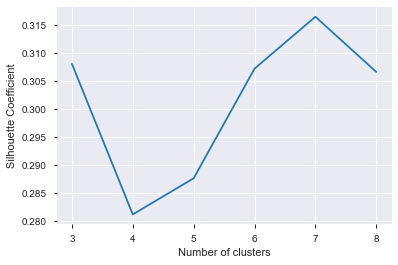

In [57]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

### Note

The solution can be 7 based on the SC score. If we take highest SC score, 7 segment solution is best

### Segment Distribution

In [58]:
ccms_num.cluster_7.value_counts()/sum(ccms_num.cluster_7.value_counts())

0    0.377430
6    0.225698
2    0.106034
1    0.083687
3    0.082458
5    0.064804
4    0.059888
Name: cluster_7, dtype: float64

# Profiling

In [59]:
ccms_num.cluster_3.value_counts()*100/sum(ccms_num.cluster_3.value_counts())

0    48.234637
1    37.027933
2    14.737430
Name: cluster_3, dtype: float64

In [60]:
pd.Series.sort_index(ccms_num.cluster_6.value_counts())

0    1115
1    2508
2    3423
3     551
4     761
5     592
Name: cluster_6, dtype: int64

In [61]:
size=pd.concat([pd.Series(ccms_num.cluster_3.size), pd.Series.sort_index(ccms_num.cluster_3.value_counts()), pd.Series.sort_index(ccms_num.cluster_4.value_counts()),
           pd.Series.sort_index(ccms_num.cluster_5.value_counts()), pd.Series.sort_index(ccms_num.cluster_6.value_counts()),
           pd.Series.sort_index(ccms_num.cluster_7.value_counts()), pd.Series.sort_index(ccms_num.cluster_8.value_counts())])

In [62]:
size

0    8950
0    4317
1    3314
2    1319
0    3661
1    1329
2    1266
3    2694
0    3556
1    2535
2    1129
3     678
4    1052
0    1115
1    2508
2    3423
3     551
4     761
5     592
0    3378
1     749
2     949
3     738
4     536
5     580
6    2020
0     521
1    2699
2     736
3     546
4    1969
5     936
6    1038
7     505
dtype: int64

In [63]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/ccms_num.cluster_3.size, columns=['Seg_Pct'])
Seg_size.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8950,4317,3314,1319,3661,1329,1266,2694,3556,2535,...,580,2020,521,2699,736,546,1969,936,1038,505


In [64]:
Seg_Pct.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_Pct,1.0,0.482346,0.370279,0.147374,0.40905,0.148492,0.141453,0.301006,0.397318,0.28324,...,0.064804,0.225698,0.058212,0.301564,0.082235,0.061006,0.22,0.104581,0.115978,0.056425


In [65]:
pd.concat([Seg_size.T, Seg_Pct.T], axis=0)

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8950.0,4317.000000,3314.000000,1319.000000,3661.00000,1329.000000,1266.000000,2694.000000,3556.000000,2535.00000,...,580.000000,2020.000000,521.000000,2699.000000,736.000000,546.000000,1969.00,936.000000,1038.000000,505.000000
Seg_Pct,1.0,0.482346,0.370279,0.147374,0.40905,0.148492,0.141453,0.301006,0.397318,0.28324,...,0.064804,0.225698,0.058212,0.301564,0.082235,0.061006,0.22,0.104581,0.115978,0.056425


In [66]:
ccms_num.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,MONTHLY_CASH_ADVANCE,LIMIT_USAGE,PTMR,AVERAGE_PURCHASE_TRX,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,0.000000,0.040901,1.446508,47.700000,0,0,0,2,0,1
1,3202.467416,0.909091,0.00,0.00,0.0,4647.169122,0.000000,0.000000,0.000000,0.250000,...,425.548562,0.457495,3.826241,55.458333,1,3,1,1,6,4
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.332687,0.991682,64.430833,0,3,1,1,6,4
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,17.149001,0.222223,2.170495,278.554000,2,1,4,5,5,7
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,0.000000,0.681429,2.771075,16.000000,0,3,1,1,6,4


In [67]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
Profling_output = pd.concat([ccms_num.apply(lambda x: x.mean()).T, ccms_num.groupby('cluster_3').apply(lambda x: x.mean()).T, ccms_num.groupby('cluster_4').apply(lambda x: x.mean()).T,
          ccms_num.groupby('cluster_5').apply(lambda x: x.mean()).T, ccms_num.groupby('cluster_6').apply(lambda x: x.mean()).T,
          ccms_num.groupby('cluster_7').apply(lambda x: x.mean()).T, ccms_num.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)


In [68]:
Profling_output

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
BALANCE,1452.399593,381.807720,2720.757102,1769.615916,279.375029,1198.478251,4541.540714,1720.050571,288.686559,1636.984732,...,809.906266,1679.096492,761.367501,271.167852,1964.168940,3716.503850,1695.540421,4545.631644,347.894091,873.738690
BALANCE_FREQUENCY,0.883252,0.790279,0.981994,0.939454,0.772331,0.914456,0.988729,0.969027,0.775041,0.969265,...,0.776522,0.977699,0.943830,0.782776,0.942841,0.989140,0.980529,0.988632,0.786617,0.780448
PURCHASES,823.863022,480.337065,380.936352,3061.058276,463.571486,2779.155380,962.055282,283.956700,449.411468,284.935680,...,1090.240585,313.752767,3451.387032,357.323138,255.424687,3225.109694,320.136577,423.073729,1040.158179,1101.096375
ONEOFF_PURCHASES,447.948730,222.723896,198.208871,1812.568516,198.891999,1671.866912,500.666332,157.848114,189.692295,156.558095,...,810.437507,160.607262,2044.331916,131.842790,155.102908,1832.998212,164.927161,199.677051,519.621802,836.081228
INSTALLMENTS_PURCHASES,336.336040,257.656199,181.193440,983.647223,264.911859,890.138965,408.707662,126.186584,259.915431,128.446780,...,255.738517,153.255608,1080.748743,225.891689,100.368954,1092.307647,155.298501,222.149404,513.443444,238.644332
CASH_ADVANCE,817.161146,351.292008,1554.478246,489.403905,261.648231,338.274767,2271.015353,1125.102257,257.063302,1048.561671,...,389.335824,699.959521,267.050054,192.081525,2624.766662,901.679172,694.849450,2317.685862,475.112135,398.429939
PURCHASES_FREQUENCY,0.490351,0.506644,0.331974,0.834946,0.534140,0.786249,0.465773,0.296421,0.532153,0.303964,...,0.293616,0.339994,0.901936,0.536774,0.231390,0.891842,0.343460,0.352477,0.644930,0.271482
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.150671,0.125302,0.565805,0.148929,0.528605,0.203541,0.113796,0.145832,0.115612,...,0.161162,0.120656,0.671950,0.124357,0.107633,0.564379,0.123046,0.122622,0.292977,0.153939
PURCHASES_INSTALLMENTS_FREQUENCY,0.364437,0.382026,0.236125,0.629259,0.409903,0.571411,0.358239,0.203461,0.410240,0.209195,...,0.130486,0.242522,0.680154,0.421149,0.146839,0.715086,0.244672,0.259026,0.471267,0.116397
CASH_ADVANCE_FREQUENCY,0.127637,0.055509,0.246115,0.066031,0.041164,0.050865,0.287155,0.208061,0.040748,0.198827,...,0.058425,0.134679,0.037829,0.034833,0.451107,0.117156,0.135412,0.294696,0.057862,0.059655


In [69]:
Profling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output], axis=0)

In [70]:
Profling_output_final

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8950.000000,4317.000000,3314.000000,1319.000000,3661.000000,1329.000000,1266.000000,2694.000000,3556.000000,2535.000000,...,580.000000,2020.000000,521.000000,2699.000000,736.000000,546.000000,1969.000000,936.000000,1038.000000,505.000000
Seg_Pct,1.000000,0.482346,0.370279,0.147374,0.409050,0.148492,0.141453,0.301006,0.397318,0.283240,...,0.064804,0.225698,0.058212,0.301564,0.082235,0.061006,0.220000,0.104581,0.115978,0.056425
BALANCE,1452.399593,381.807720,2720.757102,1769.615916,279.375029,1198.478251,4541.540714,1720.050571,288.686559,1636.984732,...,809.906266,1679.096492,761.367501,271.167852,1964.168940,3716.503850,1695.540421,4545.631644,347.894091,873.738690
BALANCE_FREQUENCY,0.883252,0.790279,0.981994,0.939454,0.772331,0.914456,0.988729,0.969027,0.775041,0.969265,...,0.776522,0.977699,0.943830,0.782776,0.942841,0.989140,0.980529,0.988632,0.786617,0.780448
PURCHASES,823.863022,480.337065,380.936352,3061.058276,463.571486,2779.155380,962.055282,283.956700,449.411468,284.935680,...,1090.240585,313.752767,3451.387032,357.323138,255.424687,3225.109694,320.136577,423.073729,1040.158179,1101.096375
ONEOFF_PURCHASES,447.948730,222.723896,198.208871,1812.568516,198.891999,1671.866912,500.666332,157.848114,189.692295,156.558095,...,810.437507,160.607262,2044.331916,131.842790,155.102908,1832.998212,164.927161,199.677051,519.621802,836.081228
INSTALLMENTS_PURCHASES,336.336040,257.656199,181.193440,983.647223,264.911859,890.138965,408.707662,126.186584,259.915431,128.446780,...,255.738517,153.255608,1080.748743,225.891689,100.368954,1092.307647,155.298501,222.149404,513.443444,238.644332
CASH_ADVANCE,817.161146,351.292008,1554.478246,489.403905,261.648231,338.274767,2271.015353,1125.102257,257.063302,1048.561671,...,389.335824,699.959521,267.050054,192.081525,2624.766662,901.679172,694.849450,2317.685862,475.112135,398.429939
PURCHASES_FREQUENCY,0.490351,0.506644,0.331974,0.834946,0.534140,0.786249,0.465773,0.296421,0.532153,0.303964,...,0.293616,0.339994,0.901936,0.536774,0.231390,0.891842,0.343460,0.352477,0.644930,0.271482
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.150671,0.125302,0.565805,0.148929,0.528605,0.203541,0.113796,0.145832,0.115612,...,0.161162,0.120656,0.671950,0.124357,0.107633,0.564379,0.123046,0.122622,0.292977,0.153939


In [71]:
#Profling_output_final.columns = ['Seg_' + str(i) for i in Profling_output_final.columns]
Profling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]

In [72]:
Profling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,8950.000000,4317.000000,3314.000000,1319.000000,3661.000000,1329.000000,1266.000000,2694.000000,3556.000000,2535.000000,...,580.000000,2020.000000,521.000000,2699.000000,736.000000,546.000000,1969.000000,936.000000,1038.000000,505.000000
Seg_Pct,1.000000,0.482346,0.370279,0.147374,0.409050,0.148492,0.141453,0.301006,0.397318,0.283240,...,0.064804,0.225698,0.058212,0.301564,0.082235,0.061006,0.220000,0.104581,0.115978,0.056425
BALANCE,1452.399593,381.807720,2720.757102,1769.615916,279.375029,1198.478251,4541.540714,1720.050571,288.686559,1636.984732,...,809.906266,1679.096492,761.367501,271.167852,1964.168940,3716.503850,1695.540421,4545.631644,347.894091,873.738690
BALANCE_FREQUENCY,0.883252,0.790279,0.981994,0.939454,0.772331,0.914456,0.988729,0.969027,0.775041,0.969265,...,0.776522,0.977699,0.943830,0.782776,0.942841,0.989140,0.980529,0.988632,0.786617,0.780448
PURCHASES,823.863022,480.337065,380.936352,3061.058276,463.571486,2779.155380,962.055282,283.956700,449.411468,284.935680,...,1090.240585,313.752767,3451.387032,357.323138,255.424687,3225.109694,320.136577,423.073729,1040.158179,1101.096375
ONEOFF_PURCHASES,447.948730,222.723896,198.208871,1812.568516,198.891999,1671.866912,500.666332,157.848114,189.692295,156.558095,...,810.437507,160.607262,2044.331916,131.842790,155.102908,1832.998212,164.927161,199.677051,519.621802,836.081228
INSTALLMENTS_PURCHASES,336.336040,257.656199,181.193440,983.647223,264.911859,890.138965,408.707662,126.186584,259.915431,128.446780,...,255.738517,153.255608,1080.748743,225.891689,100.368954,1092.307647,155.298501,222.149404,513.443444,238.644332
CASH_ADVANCE,817.161146,351.292008,1554.478246,489.403905,261.648231,338.274767,2271.015353,1125.102257,257.063302,1048.561671,...,389.335824,699.959521,267.050054,192.081525,2624.766662,901.679172,694.849450,2317.685862,475.112135,398.429939
PURCHASES_FREQUENCY,0.490351,0.506644,0.331974,0.834946,0.534140,0.786249,0.465773,0.296421,0.532153,0.303964,...,0.293616,0.339994,0.901936,0.536774,0.231390,0.891842,0.343460,0.352477,0.644930,0.271482
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.150671,0.125302,0.565805,0.148929,0.528605,0.203541,0.113796,0.145832,0.115612,...,0.161162,0.120656,0.671950,0.124357,0.107633,0.564379,0.123046,0.122622,0.292977,0.153939


In [73]:
# Profling_output_final.to_csv('Profiling_output.csv')

In [74]:
ccms_num[ccms_num.cluster_7==2].head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,MONTHLY_CASH_ADVANCE,LIMIT_USAGE,PTMR,AVERAGE_PURCHASE_TRX,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
5,1809.828751,1.0,1333.28,0.0,1333.28,0.000000,0.666667,0.0,0.583333,0.000000,...,0.000000,0.966694,0.581601,166.660000,1,2,3,0,2,5
15,5909.111808,1.0,1611.70,0.0,1611.70,2301.491267,0.500000,0.0,0.500000,0.166667,...,191.790939,0.860777,0.944800,146.518182,1,2,2,0,2,5
19,3577.970933,1.0,398.64,0.0,398.64,0.000000,1.000000,0.0,1.000000,0.000000,...,0.000000,0.894493,0.454553,33.220000,1,2,2,0,2,5
20,2016.684686,1.0,176.68,0.0,176.68,0.000000,0.666667,0.0,0.666667,0.000000,...,0.000000,0.966694,0.454553,22.085000,1,2,2,0,2,5
24,5368.571219,1.0,0.00,0.0,0.00,798.949863,0.000000,0.0,0.000000,0.363636,...,72.631806,0.894762,0.858615,55.458333,1,2,2,0,2,5


### Elbow Analysis 

In [75]:
cluster_range = range( 1, 20 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( ccms_scaled2 )
    cluster_errors.append( clusters.inertia_ )

In [76]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df[0:10]

,num_clusters,cluster_errors
0,1,71600.000000
1,2,52974.893136
2,3,40272.014352
3,4,34659.270565
4,5,30766.980045
5,6,27239.152185
6,7,24553.433059
7,8,22256.704070
8,9,20683.154475
9,10,19265.477942


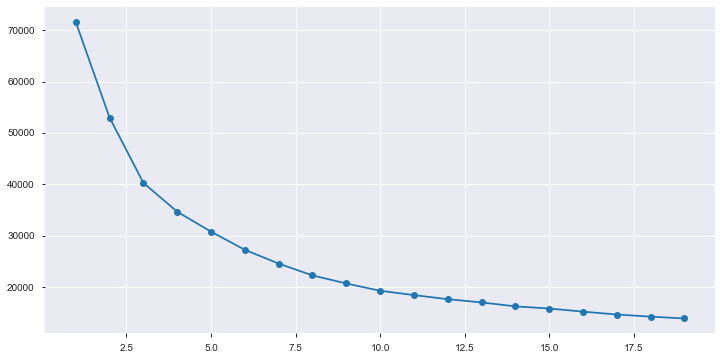

In [77]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

### Note:
- The elbow diagram shows that the gain in explained variance reduces significantly from 5 to 6 to 7. So, optimal number of clusters could either 6 or 7. 
- The actual number of clusters chosen can be finally based on business context and convenience of dealing with number of segments or clusters.

#  DBSCAN clustering
### Density-based spatial clustering of applications with noise (DBSCAN) 

In [78]:
# DBSCAN with eps=1 and min_samples=3
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=2.05, min_samples=10)
db.fit(ccms_scaled2)

DBSCAN(algorithm='auto', eps=2.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [79]:
pd.Series(db.labels_).value_counts()

 0    8943
-1       7
dtype: int64

In [80]:
# review the cluster labels
db.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [81]:
# save the cluster labels and sort by cluster
ccms_num['DB_cluster'] = db.labels_

In [82]:
# review the cluster centers
ccms_num.groupby('DB_cluster').mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,MONTHLY_CASH_ADVANCE,LIMIT_USAGE,PTMR,AVERAGE_PURCHASE_TRX,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
DB_cluster,,,,,,,,,,,,,,,,,,,,,
-1,3706.668372,0.870130,2588.122714,1845.151714,568.098214,3623.077105,0.572511,0.237477,0.420068,0.392857,...,329.269141,0.461706,13.281601,237.553469,1.857143,1.285714,3.428571,3.857143,4.428571,4.714286
0,1450.635098,0.883262,822.482074,446.855090,336.154632,814.964857,0.490286,0.202430,0.364394,0.127430,...,73.436485,0.383918,4.657626,72.612067,0.664095,1.334452,1.231242,1.899139,2.459354,3.141563


# --------------------------------------------------------------------------------------------------------------